# MAUP - Raster

Let's investigate how the modifiable areal unit problem manifests in raster analysis as well as to experiment with aggregation of raster data. Moreover, this exercise explores how examination of MAUP affects can be automated.

In [2]:
inLibraries = list('repr','rgdal','spdep','rgeos','RColorBrewer','classInt','raster')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Read Observed Measurements

In this exercise, let's look at some pollution data collected for New York City (https://catalog.data.gov/dataset/nyccas-air-pollution-rasters).  I basically downloaded this data and simply converted it to .tiff format to make it easier to use on jupyterhub.  The only other modification I had to make to some the files was to set the CRS properly in cases in which it was missing. 

Raster files for the December 2013-December 2015 period represent estimates of NO (nitric oxide), PM (fine particular matter), BC (black carbon), NO2 (carbon dioxide) collected over the year and 03 (ozone) estimated for summer.

Plot the rasters for aa7_bc (black carbon) and aa7_no (nitric oxide) side-by-side.

In [3]:
directory <- "/dsa/data/geospatial/DS8612/nypollution/"
nyc_files <- list.files(directory)
nyc_files

[1] "aa6_bc300m.tfw"          "aa6_bc300m.tif"         
 [3] "aa6_bc300m.tif.aux.xml"  "aa6_bc300m.tif.ovr"     
 [5] "aa6_bc300m.tif.xml"      "aa6_no2300m.tfw"        
 [7] "aa6_no2300m.tif"         "aa6_no2300m.tif.aux.xml"
 [9] "aa6_no2300m.tif.ovr"     "aa6_no2300m.tif.xml"    
[11] "aa6_no300m.tfw"          "aa6_no300m.tif"         
[13] "aa6_no300m.tif.aux.xml"  "aa6_no300m.tif.ovr"     
[15] "aa6_no300m.tif.xml"      "aa6_pm300m.tfw"         
[17] "aa6_pm300m.tif"          "aa6_pm300m.tif.aux.xml" 
[19] "aa6_pm300m.tif.ovr"      "aa6_pm300m.tif.xml"     
[21] "aa7_bc300m.tfw"          "aa7_bc300m.tif"         
[23] "aa7_bc300m.tif.aux.xml"  "aa7_bc300m.tif.ovr"     
[25] "aa7_bc300m.tif.xml"      "aa7_no2300m.tfw"        
[27] "aa7_no2300m.tif"         "aa7_no2300m.tif.aux.xml"
[29] "aa7_no2300m.tif.ovr"     "aa7_no2300m.tif.xml"    
[31] "aa7_no300m.tfw"          "aa7_no300m.tif"         
[33] "aa7_no300m.tif.aux.xml"  "aa7_no300m.tif.ovr"     
[35] "aa7_no300m.tif.xml"      "aa7_pm300m.tfw"         
[37] "aa7_pm300m.tif"          "aa7_pm300m.tif.aux.xml" 
[39] "aa7_pm300m.tif.ovr"      "aa7_pm300m.tif.xml"     
[41] "s6_o3300m.tfw"           "s6_o3300m.tif"          
[43] "s6_o3300m.tif.aux.xml"   "s6_o3300m.tif.ovr"      
[45] "s6_o3300m.tif.xml"       "s7_o3300m.tfw"          
[47] "s7_o3300m.tif"           "s7_o3300m.tif.aux.xml"  
[49] "s7_o3300m.tif.ovr"       "s7_o3300m.tif.xml"      
[51] "w6_so2300m.tfw"          "w6_so2300m.tif"         
[53] "w6_so2300m.tif.aux.xml"  "w6_so2300m.tif.ovr"     
[55] "w6_so2300m.tif.xml"      "w7_so2300m.tfw"         
[57] "w7_so2300m.tif"          "w7_so2300m.tif.aux.xml" 
[59] "w7_so2300m.tif.ovr"      "w7_so2300m.tif.xml"

In [4]:
# only return the filename if it ends in .tif
tifs <- lapply(nyc_files, FUN = function(x) {
    namesArray <- strsplit(x, '.', fixed = TRUE)
    namesArray <- namesArray[[1]]
    
    if (namesArray[2] == "tif" 
            && length(namesArray) == 2){
        return(namesArray[1])
    }
} )

# remove all the NULLs
tifs <- tifs[!sapply(tifs, is.null)]
tifs

[[1]]
[1] "aa6_bc300m"

[[2]]
[1] "aa6_no2300m"

[[3]]
[1] "aa6_no300m"

[[4]]
[1] "aa6_pm300m"

[[5]]
[1] "aa7_bc300m"

[[6]]
[1] "aa7_no2300m"

[[7]]
[1] "aa7_no300m"

[[8]]
[1] "aa7_pm300m"

[[9]]
[1] "s6_o3300m"

[[10]]
[1] "s7_o3300m"

[[11]]
[1] "w6_so2300m"

[[12]]
[1] "w7_so2300m"

In [5]:
ext <- ".tif"
bc <- paste(directory, tifs[5], ext, sep = "")
no <- paste(directory, tifs[7], ext, sep = "")

bcRaster <- raster(bc)
noRaster <- raster(no)

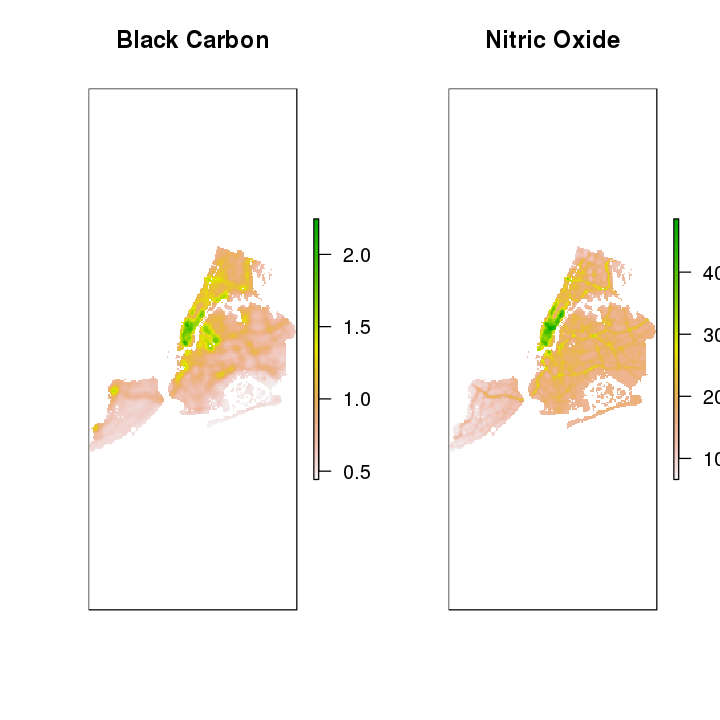

In [6]:
par(mfrow = c(1, 2))

plot(bcRaster, main = "Black Carbon", axes = FALSE)
plot(noRaster, main = "Nitric Oxide", axes = FALSE)

Implement an iterative routine that automates the computation of linear regression and local Moran for at least 3 different levels of spatial aggregation for the aa7_bc (black carbon) and aa7_no (nitric oxide) rasters. Retrieve the z-scores from the local Moran tests. 


In [7]:
getZvalues <- function(aggValues){
    
    zVals <- list()
    rasters <- list()
    
    for (agg in aggValues){

        bcR <- bcRaster
        noR <- noRaster
    

        if (agg > 1){
            aggFactor <- c(agg, agg)

            bcR <- aggregate(bcR, 
                              fact = aggFactor, 
                              fun = mean, 
                              expand = T)

            noR <- aggregate(noR, 
                             fact = aggFactor,
                             fun = mean,
                             expand = T)
        }
        
        bcRCopy <- raster(bcR)
        noRCopy <- raster(noR)

        print("")
        print("")
        print(paste("AGGREGATION FACTOR:", agg, "x", agg, "..........."))

        lm <- lm(bcR[] ~ noR[])
        resids <- as.data.frame(residuals(lm))
        resids$id <- row.names(resids)
        colnames(resids) <- c("resid", "id")

        print("LINEAR REGRESSION SUMMARY:")
        print(summary(lm))

        numcells <- ncell(bcR)
        numcols <- ncol(bcR)
        numrows <- nrow(bcR)

        nb <- cell2nb(numrows, numcols, type = "rook", 
                          torus = FALSE)

        listb <- nb2listw(nb, style = "B", zero.policy = TRUE)
        cellList <- values(bcR)

        celldf <- data.frame(cellvalue = cellList)
        celldf$id <- row.names(celldf)
        celldf$id2 <- row.names(celldf)

        cs <- merge(celldf, resids, by.x = "id", by.y = "id", 
                        all.x = TRUE, sort = TRUE)

        celldf <- cs[order(cs$id), ]

        localmoran <- localmoran(celldf$resid, listb, zero.policy = TRUE,
                                    na.action = na.exclude, 
                                    alternative = "greater", 
                                    p.adjust.method = "none",
                                    mlvar = TRUE,
                                    spChk = NULL)
        
        print("--------------------------------")
        print("Z VALUES FROM LOCAL MORAN (first 10):")
        
        row.names(localmoran) <- NULL
        celldf$z <- localmoran[, 4]
        zValues <- localmoran[, 4]
        
        celldf$z[is.na(celldf$z)] <- 0 
        zValues[is.na(zValues)] <- 0        
        
        print(zValues[1:10])
        
        zVals[[agg]] <- zValues
        
        for (i in 1:length(zValues)){
            newid <- as.numeric(celldf$id[i])
            bcRCopy[newid] <- celldf$z[i]
        }
        
        
        rasters[[agg]] <- bcRCopy
        
        print("")
        print("")
        print("==============================================")
        print("==============================================")
    }
    
    results <- list(zVals, rasters)    
    return(results)
}


In [8]:
aggValues <- cbind(1, 2, 3)
res <- getZvalues(aggValues)

[1] ""
[1] ""
[1] "AGGREGATION FACTOR: 1 x 1 ..........."
[1] "LINEAR REGRESSION SUMMARY:"

Call:
lm(formula = bcR[] ~ noR[])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39342 -0.12504 -0.02161  0.09712  0.96414 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.2209021  0.0065555   33.70   <2e-16 ***
noR[]       0.0361566  0.0003639   99.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1837 on 8758 degrees of freedom
  (15575 observations deleted due to missingness)
Multiple R-squared:   0.53,	Adjusted R-squared:  0.5299 
F-statistic:  9874 on 1 and 8758 DF,  p-value: < 2.2e-16

[1] "--------------------------------"
[1] "Z VALUES FROM LOCAL MORAN (first 10):"
 [1]  0.0000000  0.0000000  0.0000000  0.0000000  0.1779139 -0.1582665
 [7]  0.3030735  0.3395392  0.2019682  0.2040682
[1] ""
[1] ""
[1] "=============================================="
[1] "==========================

Iteratively retrieve the rasters output from the previous task using a looping routine. For three of the levels of aggregation, plot the z-scores associate with the 0.90 and 0.95 confidence levels in a side-by-side plot

In [9]:
length(res)

[1] 2

In [10]:
zScores <- res[[1]]
length(zScores)

[1] 3

In [11]:
rasters <- res[[2]]
length(rasters)

[1] 3

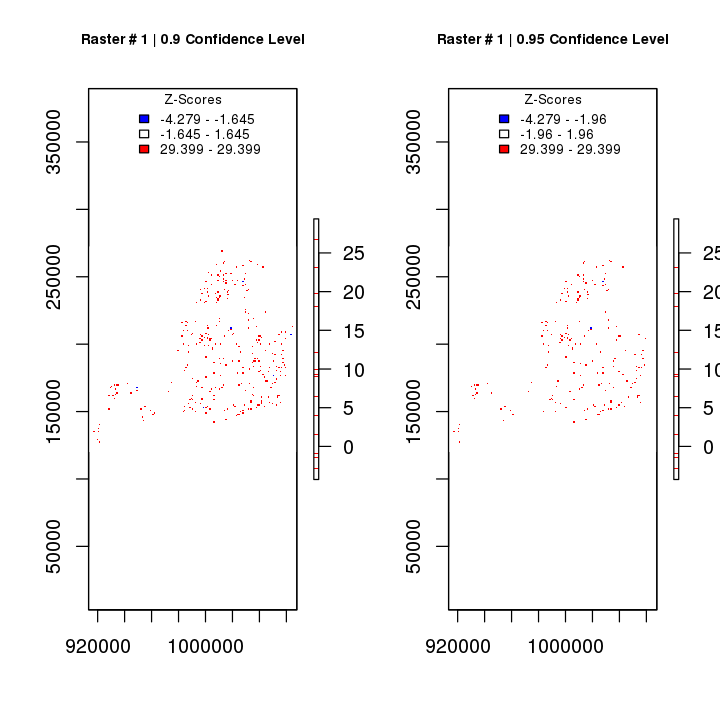

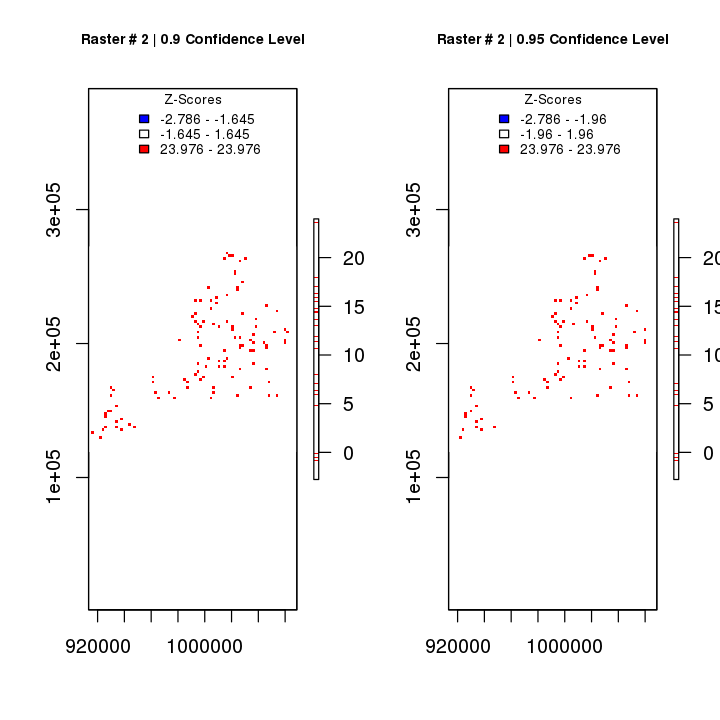

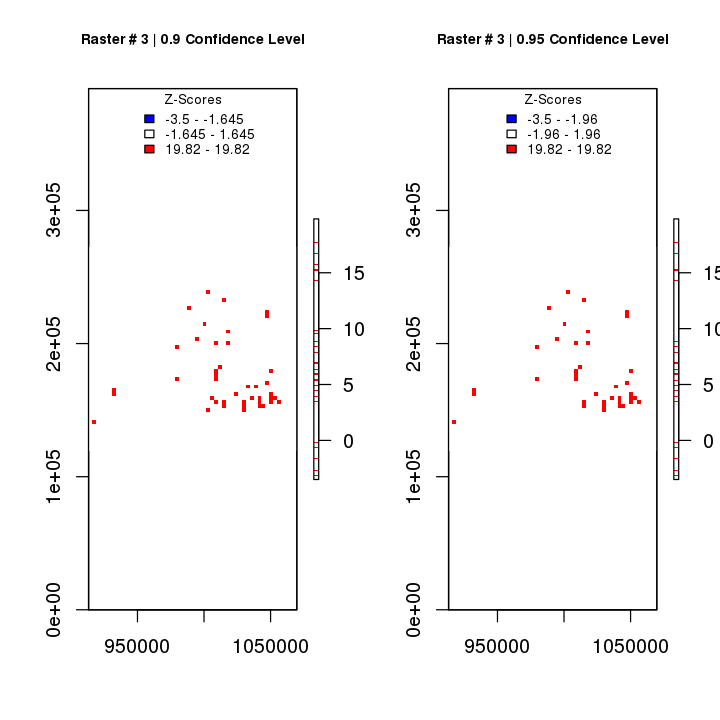

In [73]:
probs <- c(0.90, 0.95)

i <- 0

for (r in rasters){
    i <- i + 1
    par(mfrow=c(1,2))
    for (p in probs){       
        pr <- p         
        
        inpr <- 1 - ((1 - pr)/ 2)
        errorZ <- qnorm(inpr, lower.tail = TRUE)
        zNormal <- 0 + errorZ

        ncz1 <- 2
        ncz2 <- 3

        ints <- classIntervals(zScores[[i]], n = ncz1, style = "fixed",
                                  fixedBreaks = c(min(zScores[[i]]), 
                                                  -zNormal,
                                                  zNormal, 
                                                  max(zScores[[i]])))
        
        pal <-  c("blue","white","red")
        cols <- findColours(ints, pal)
        title <- paste("Raster #", i, "|", pr, "Confidence Level")
        plot(r, col = cols, main = title, cex.main = 0.7)

        brks <- round(ints$brks, ncz2)
        
        leg <- paste(brks[-ncz2], brks[-1], sep = " - ")

        legend("top", fill = pal, legend = leg, bty = "n", title = "Z-Scores", cex = 0.7)
    }
}